## **Part 1: Set Up the Code/Preprocessing**
**Link to Original Data: https://www.kaggle.com/datasets/fifthtribe/how-isis-uses-twitter?resource=download**

**Setup + Install Relevant Packages**

In [20]:
import numpy as np
import scipy
import pandas as pd
import time
import random
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
np.random.seed(0)
random.seed(0)

**Link to Github + Read in Data**

In [21]:
# Github link
! git clone https://github.com/Ldelatorre81/Poli_179_final_project.git

# Data
df = pd.read_csv("Poli_179_final_project/data/DatasetISISTweets.csv")
df

fatal: destination path 'Poli_179_final_project' already exists and is not an empty directory.


,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...,...,...,...,...,...,...,...,...
17405,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:46,#Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:50,#Breaking\n\n Iraqi forces bulldozer destroyed...
17407,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:51,#Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 16:07,#PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...


**Data Preporcessing**

In [22]:
# Making all tweets lowercase
df['tweets'] = df['tweets'].str.lower()

# Removing URLs from all the tweets
df['tweets'] = df['tweets'].str.replace(r'\bhttps?\b', '', regex=True)

**Subsetting Data by Year (2015 & 2016) and Follower Count (Above and Below Median)**

In [23]:
# Subset the data into 2015 and 2016
df['time'] = pd.to_datetime(df['time'])
df_2015 = df[df['time'] < '2016-01-01']
df_2016 = df[df['time'] >= '2016-01-01']

# Subset the data into above and below median follower count
median_followers = df['followers'].median()
df_above_median = df[df['followers'] > median_followers]
df_below_median = df[df['followers'] <= median_followers]

**Turning Subsets into Document-Feature Matrices (DFMs)**

In [24]:
# Turning subsets into document-feature matrices (dfm) + remove stop words
def preprocess_and_transform(df_subset):
    vectorizer = CountVectorizer(stop_words="english",
                                 analyzer="word",
                                 token_pattern=r'(?u)\b[a-zA-Z]{2,}\b', # remove numbers
                                 min_df=3,
                                 max_df=0.95,
                                 binary=True)
    X = vectorizer.fit_transform(df_subset['tweets'])
    dfm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return dfm, vectorizer, X

dfm_2015, vrizer2015, X_2015 = preprocess_and_transform(df_2015)
dfm_2016, vrizer2016, X_2016 = preprocess_and_transform(df_2016)
dfm_above_median, vrizer_above_median, X_above_median = preprocess_and_transform(df_above_median)
dfm_below_median, vrizer_below_median, X_below_median = preprocess_and_transform(df_below_median)

## **Part 2: Topic Modeling Using Latent Dirichlet Allocation (LDA)**

**Define Relevant Functions + Number of Topics**

In [25]:
# Define a function to compute the coherence score
def compute_coherence_score(texts, topics):
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_model_lda = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

# LDA Analysis function
# Function to get topics from LDA model
def get_topics(lda_model, vectorizer):
    keywords = np.array(vectorizer.get_feature_names_out())
    topics = []
    for topic_weights in lda_model.components_:
        top_keywords_locs = (-topic_weights).argsort()[:10]
        topics.append([keywords[i] for i in top_keywords_locs])
    return topics

# Define the number of topics
num_topics = 5

**LDA for 2015/2016 Subsets**

In [26]:
# LDA analysis for 2015/2016 Subsets
def lda_analysis(year, X, vrizer):
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_model.fit(X)
    topics = get_topics(lda_model, vrizer)
    texts = [list(vrizer.get_feature_names_out()[doc.nonzero()[1]]) for doc in X]
    coherence_score = compute_coherence_score(texts, topics)

    print(f"Top words for {year} Data:")
    for i, topic in enumerate(topics):
        print(f"Topic {i+1}: {', '.join(topic)}")
    print(f"Coherence Score for {year} Data: {coherence_score}")

lda_analysis("2015", X_2015, vrizer2015)
lda_analysis("2016", X_2016, vrizer2016)

# Define and train LDA models for 2015 and 2016
lda_model_2015 = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model_2016 = LatentDirichletAllocation(n_components=num_topics, random_state=0)

# Fit LDA models to the data
lda_model_2015.fit(X_2015)
lda_model_2016.fit(X_2016)

Top words for 2015 Data:
Topic 1: islamicstate, iraqi, army, ramadi, amp, soldiers, west, city, know, aleppo
Topic 2: akhijibran, lol, amp, like, somaliyyah, killed, ishmael, media, syrian, regime
Topic 3: rt, syria, isis, al, ramiallolah, russia, killed, abu, muslims, sheikh
Topic 4: allah, rt, soon, wilayathalab, akhi, new, twitter, ya, statement, coming
Topic 5: islamic, state, wilayatninawa, know, syria, rt, fighters, just, news, did
Coherence Score for 2015 Data: 0.38870966790050004
Top words for 2016 Data:
Topic 1: rt, la, le, est, isis, twitter, les, des, je, pas
Topic 2: rt, syria, isis, amp, turkey, ypg, al, ramiallolah, aleppo, russia
Topic 3: isis, rt, syria, state, assad, islamic, aleppo, palmyra, killed, saa
Topic 4: rt, allah, al, amp, muslims, islam, don, people, like, know
Topic 5: rt, killed, isis, iraq, army, al, today, iraqi, near, soldiers
Coherence Score for 2016 Data: 0.5468517250449392


LatentDirichletAllocation(n_components=5, random_state=0)

**LDA for Above/Below Median Follower Count Subsets**

In [27]:
# LDA analysis for above/below median follower count subsets
def lda_analysis_followers(label, X, vrizer):
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_model.fit(X)
    topics = get_topics(lda_model, vrizer)
    texts = [list(vrizer.get_feature_names_out()[doc.nonzero()[1]]) for doc in X]
    coherence_score = compute_coherence_score(texts, topics)

    print(f"Top words for {label} Followers Data:")
    for i, topic in enumerate(topics):
        print(f"Topic {i+1}: {', '.join(topic)}")
    print(f"Coherence Score for {label} Followers Data: {coherence_score}")

lda_analysis_followers("Above Median", X_above_median, vrizer_above_median)
lda_analysis_followers("Below Median", X_below_median, vrizer_below_median)

# Train LDA models for above and below median follower datasets
lda_model_above_median = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model_below_median = LatentDirichletAllocation(n_components=num_topics, random_state=0)

# Fit LDA models to the data
lda_model_above_median.fit(X_above_median)
lda_model_below_median.fit(X_below_median)

Top words for Above Median Followers Data:
Topic 1: killed, isis, rt, iraq, al, army, soldiers, iraqi, today, near
Topic 2: rt, islamic, state, amp, al, syria, yes, assad, lol, people
Topic 3: rt, amp, isis, al, assad, muslims, iran, islam, saudi, time
Topic 4: syria, rt, isis, aleppo, assad, ypg, rebels, turkey, army, amp
Topic 5: le, la, est, rt, les, je, pas, des, et, en
Coherence Score for Above Median Followers Data: 0.5504254775642664
Top words for Below Median Followers Data:
Topic 1: rt, al, amp, allah, know, muslims, people, islam, just, said
Topic 2: islamicstate, army, rt, amaqagency, breaking, al, iraqi, killed, area, state
Topic 3: rt, isis, syria, ramiallolah, killed, iraq, assad, amp, al, today
Topic 4: rt, muslims, new, islamic, state, support, twitter, al, abu, account
Topic 5: rt, allah, islamic, state, al, follow, akhi, city, amp, mosul
Coherence Score for Below Median Followers Data: 0.4242624959720088


LatentDirichletAllocation(n_components=5, random_state=0)

## **Part 3: Time Series**


**# Time Series for Topic Prevalence Over Time for 2015 and 2016 Datasets**

<ipython-input-28-c525c9b648dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015['topic'] = np.argmax(topic_distribution_2015, axis=1)
<ipython-input-28-c525c9b648dc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['topic'] = np.argmax(topic_distribution_2016, axis=1)


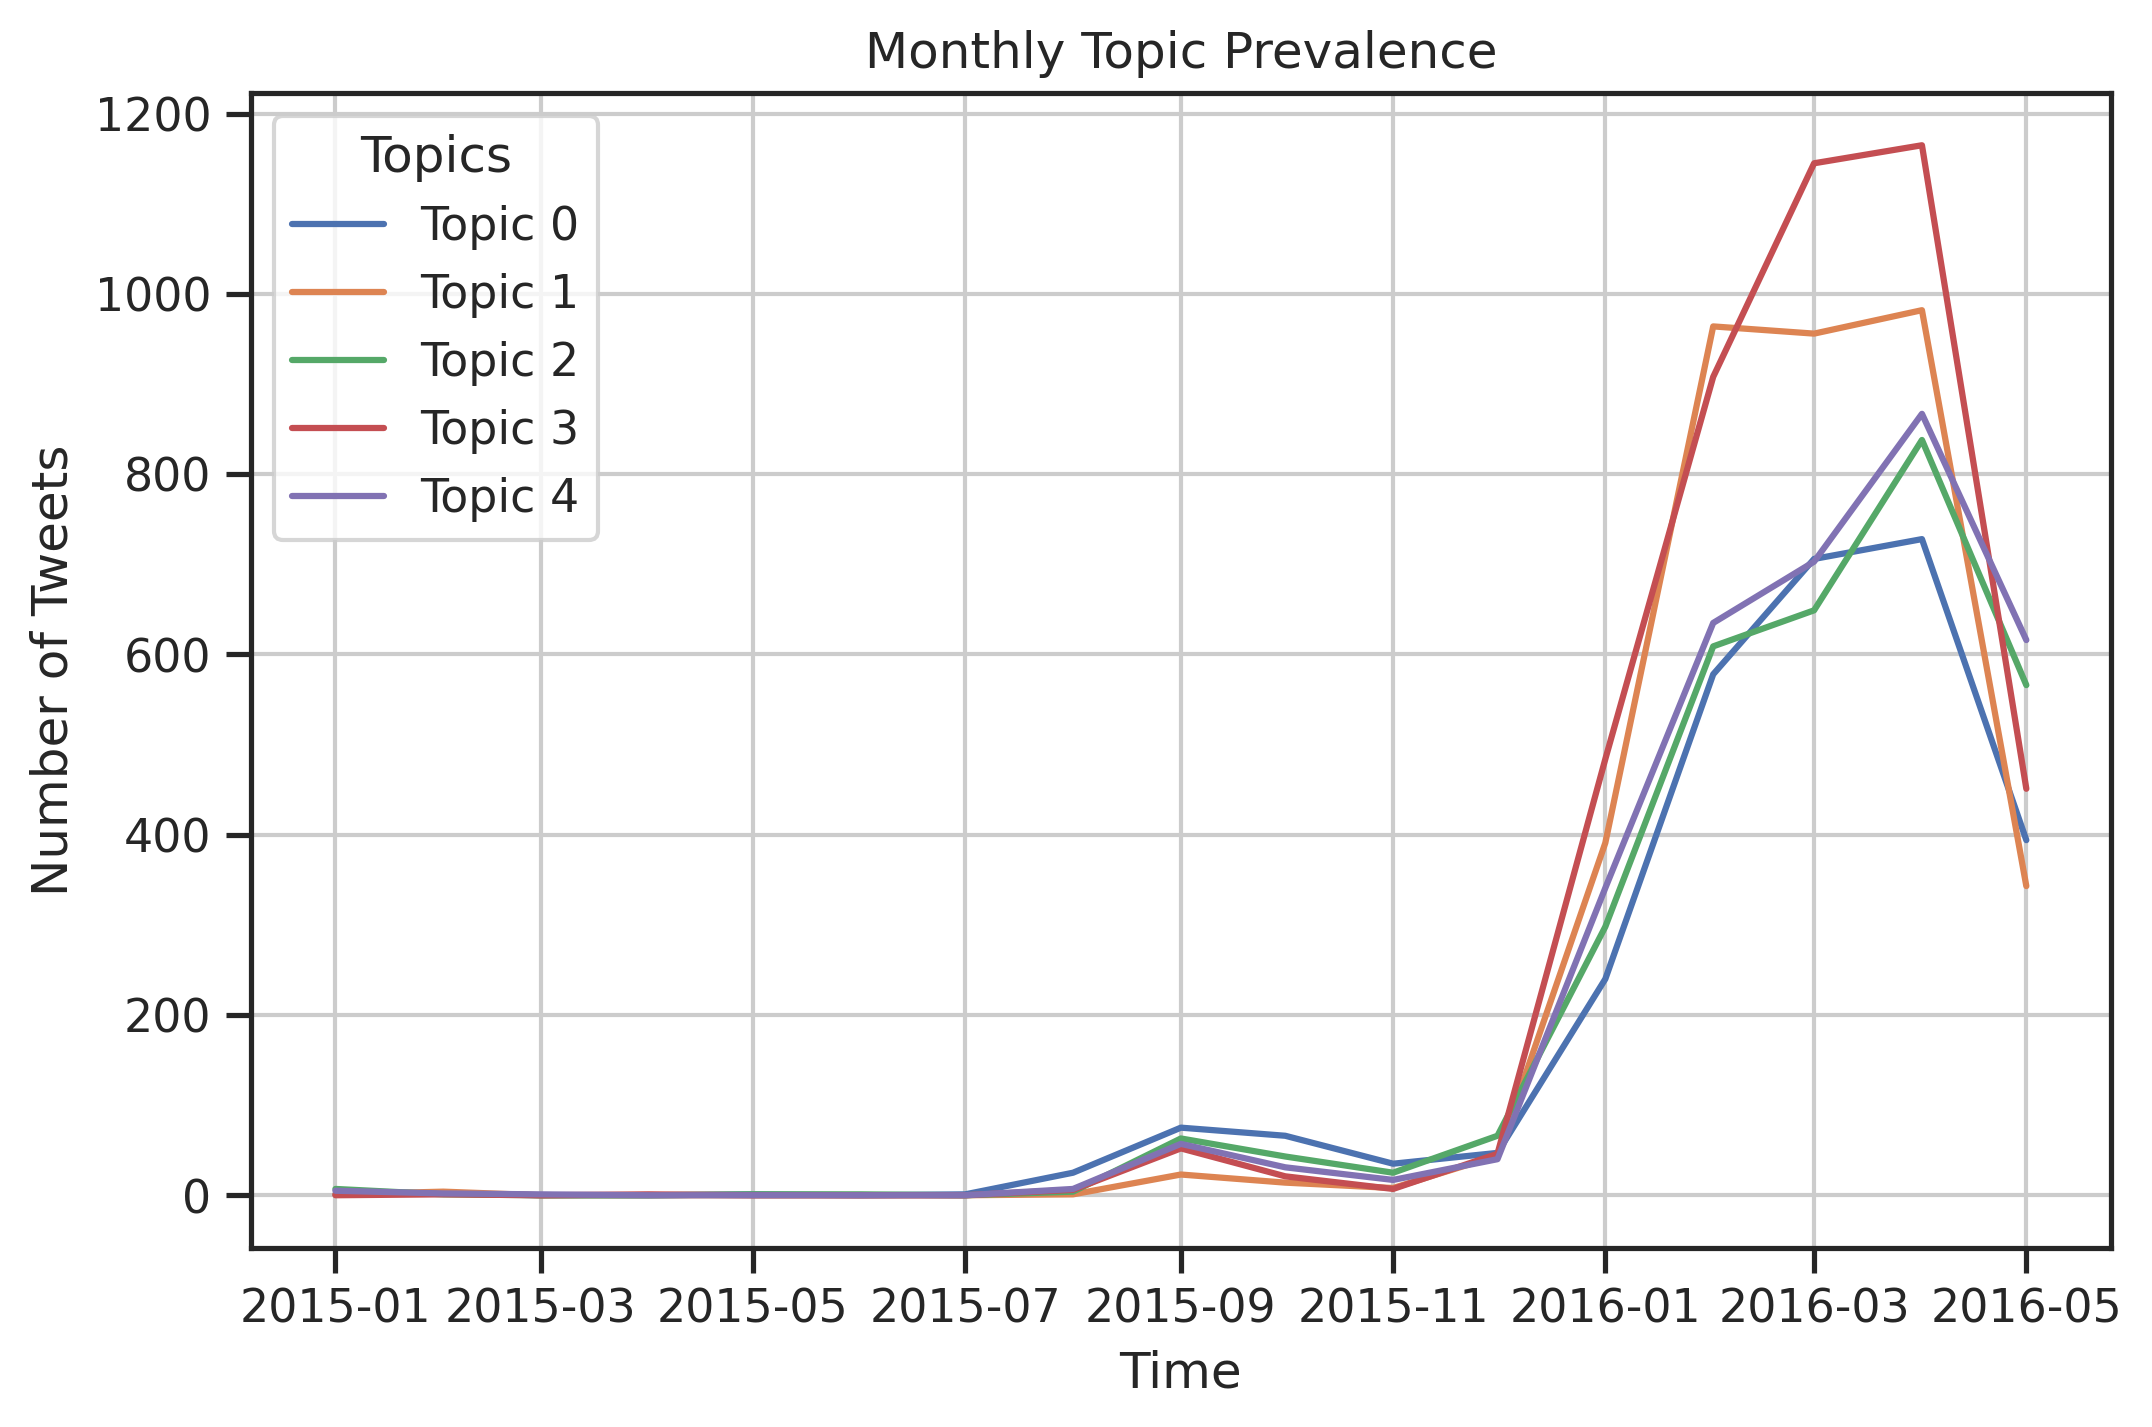

In [28]:
# Get the topic distribution for each tweet in 2015 and 2016
topic_distribution_2015 = lda_model_2015.transform(X_2015)
topic_distribution_2016 = lda_model_2016.transform(X_2016)

# Assign the most probable topic to each tweet
df_2015['topic'] = np.argmax(topic_distribution_2015, axis=1)
df_2016['topic'] = np.argmax(topic_distribution_2016, axis=1)

# Combine the two DataFrames
df_combined = pd.concat([df_2015, df_2016])

# Extract year and month
df_combined['year_month'] = df_combined['time'].dt.to_period('M')

# Count the number of tweets per topic per month
topic_prevalence = df_combined.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

# Plot the time series
plt.figure(figsize=(8, 5))
for topic in topic_prevalence.columns:
    plt.plot(topic_prevalence.index.to_timestamp(), topic_prevalence[topic], label=f'Topic {topic}')

plt.title('Monthly Topic Prevalence')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.legend(title='Topics')
plt.grid(True)
plt.show()

## **Part 4: Word Embeddings Using Word2Vec**

**Word Embeddings for 2015/2016 Subsets**




In [29]:
# Word embeddings using Word2Vec
tweets_2015 = df_2015['tweets'].apply(lambda x: x.split())
tweets_2016 = df_2016['tweets'].apply(lambda x: x.split())

model_2015 = Word2Vec(sentences=tweets_2015, vector_size=100, window=5, min_count=3, workers=4, sg=1)
model_2015.train(tweets_2015, total_examples=len(tweets_2015), epochs=10)

model_2016 = Word2Vec(sentences=tweets_2016, vector_size=100, window=5, min_count=3, workers=4, sg=1)
model_2016.train(tweets_2016, total_examples=len(tweets_2016), epochs=10)

# Example analysis: Finding similar words
word = 'isis'
similar_words_2015 = model_2015.wv.most_similar(word, topn=10)
similar_words_2016 = model_2016.wv.most_similar(word, topn=10)

print(f"Top words similar to '{word}' in 2015 data:")
print(similar_words_2015)

print(f"Top words similar to '{word}' in 2016 data:")
print(similar_words_2016)

def get_word_clusters(model, words, topn=10):
    clusters = {}
    for word in words:
        if word in model.wv:
            clusters[word] = model.wv.most_similar(word, topn=topn)
    return clusters

words_to_check = ['isis', 'syria', 'army', 'islamic']  # Example words
clusters_2015 = get_word_clusters(model_2015, words_to_check)
clusters_2016 = get_word_clusters(model_2016, words_to_check)

print("Word clusters for 2015 data:")
for word, cluster in clusters_2015.items():
    print(f"Top words similar to '{word}' in 2015 data:")
    print(cluster)

print("Word clusters for 2016 data:")
for word, cluster in clusters_2016.items():
    print(f"Top words similar to '{word}' in 2016 data:")
    print(cluster)

Top words similar to 'isis' in 2015 data:
[('over', 0.9942075610160828), ('mujahideen', 0.9937479496002197), ('up', 0.9931739568710327), ('people', 0.9927467107772827), ('fsa', 0.9922812581062317), ('muslim', 0.9920837879180908), ('caliphate', 0.9920437932014465), ('russian', 0.9916141033172607), ('&gt;&gt;', 0.9913973212242126), ('set', 0.9912270307540894)]
Top words similar to 'isis' in 2016 data:
[("isis'", 0.6108834743499756), ('isis.', 0.5598092675209045), ("al-qaeda's", 0.5383457541465759), ('long-term', 0.5343157052993774), ('@warreporter1:', 0.5219314098358154), ('tactical', 0.5189846754074097), ('fighter-jets', 0.5132838487625122), ('al-qaeda', 0.5128461718559265), ('yemen', 0.5050367712974548), ('takeover', 0.5036867260932922)]
Word clusters for 2015 data:
Top words similar to 'isis' in 2015 data:
[('over', 0.9942075610160828), ('mujahideen', 0.9937479496002197), ('up', 0.9931739568710327), ('people', 0.9927467107772827), ('fsa', 0.9922812581062317), ('muslim', 0.992083787918

**Word Embeddings for Above/Below Median Follower Count Subsets**

In [30]:
# Word embeddings using Word2Vec
tweets_above_median = df_above_median['tweets'].apply(lambda x: x.split())
tweets_below_median = df_below_median['tweets'].apply(lambda x: x.split())

model_above_median = Word2Vec(sentences=tweets_above_median, vector_size=100, window=5, min_count=3, workers=4, sg=1)
model_above_median.train(tweets_above_median, total_examples=len(tweets_above_median), epochs=10)

model_below_median = Word2Vec(sentences=tweets_below_median, vector_size=100, window=5, min_count=3, workers=4, sg=1)
model_below_median.train(tweets_below_median, total_examples=len(tweets_below_median), epochs=10)

# Example analysis: Finding similar words
word = 'isis'
similar_words_above_median = model_above_median.wv.most_similar(word, topn=10)
similar_words_below_median = model_below_median.wv.most_similar(word, topn=10)

print(f"Top words similar to '{word}' in Above Median Followers data:")
print(similar_words_above_median)

print(f"Top words similar to '{word}' in Below Median Followers data:")
print(similar_words_below_median)

def get_word_clusters(model, words, topn=10):
    clusters = {}
    for word in words:
        if word in model.wv:
            clusters[word] = model.wv.most_similar(word, topn=topn)
    return clusters

words_to_check = ['isis', 'syria', 'army', 'islamic']  # Example words
clusters_above_median = get_word_clusters(model_above_median, words_to_check)
clusters_below_median = get_word_clusters(model_below_median, words_to_check)

print("Word clusters for Above Median Followers data:")
for word, cluster in clusters_above_median.items():
    print(f"Top words similar to '{word}' in Above Median Followers data:")
    print(cluster)

print("Word clusters for Below Median Followers data:")
for word, cluster in clusters_below_median.items():
    print(f"Top words similar to '{word}' in Below Median Followers data:")
    print(cluster)

Top words similar to 'isis' in Above Median Followers data:
[('fsa', 0.6094846129417419), ('libya', 0.6062582731246948), ('isis.', 0.5978060960769653), ('saying', 0.5881218910217285), ('mock', 0.5861009359359741), ('aq', 0.5835018754005432), ('fsa,', 0.5783217549324036), ("al-qaeda's", 0.5775026679039001), ("isis'", 0.5708340406417847), ('following', 0.5613346099853516)]
Top words similar to 'isis' in Below Median Followers data:
[('us-led', 0.6166799664497375), ("isis'", 0.6002686023712158), ('isis:', 0.598963737487793), ('al-qaeda', 0.5927554965019226), ('fsa', 0.5877739787101746), ('us-sponsored', 0.5860364437103271), ('hezbollah', 0.5855970978736877), ('@warreporter1:', 0.5802932381629944), ('ypg', 0.5737988948822021), ('assad', 0.5683123469352722)]
Word clusters for Above Median Followers data:
Top words similar to 'isis' in Above Median Followers data:
[('fsa', 0.6094846129417419), ('libya', 0.6062582731246948), ('isis.', 0.5978060960769653), ('saying', 0.5881218910217285), ('moc

## **Part 5: Visual Representation for Results of 2015/2016 Subset**

**Word Cloud of LDA Results**

Word Clouds for 2015 Data:


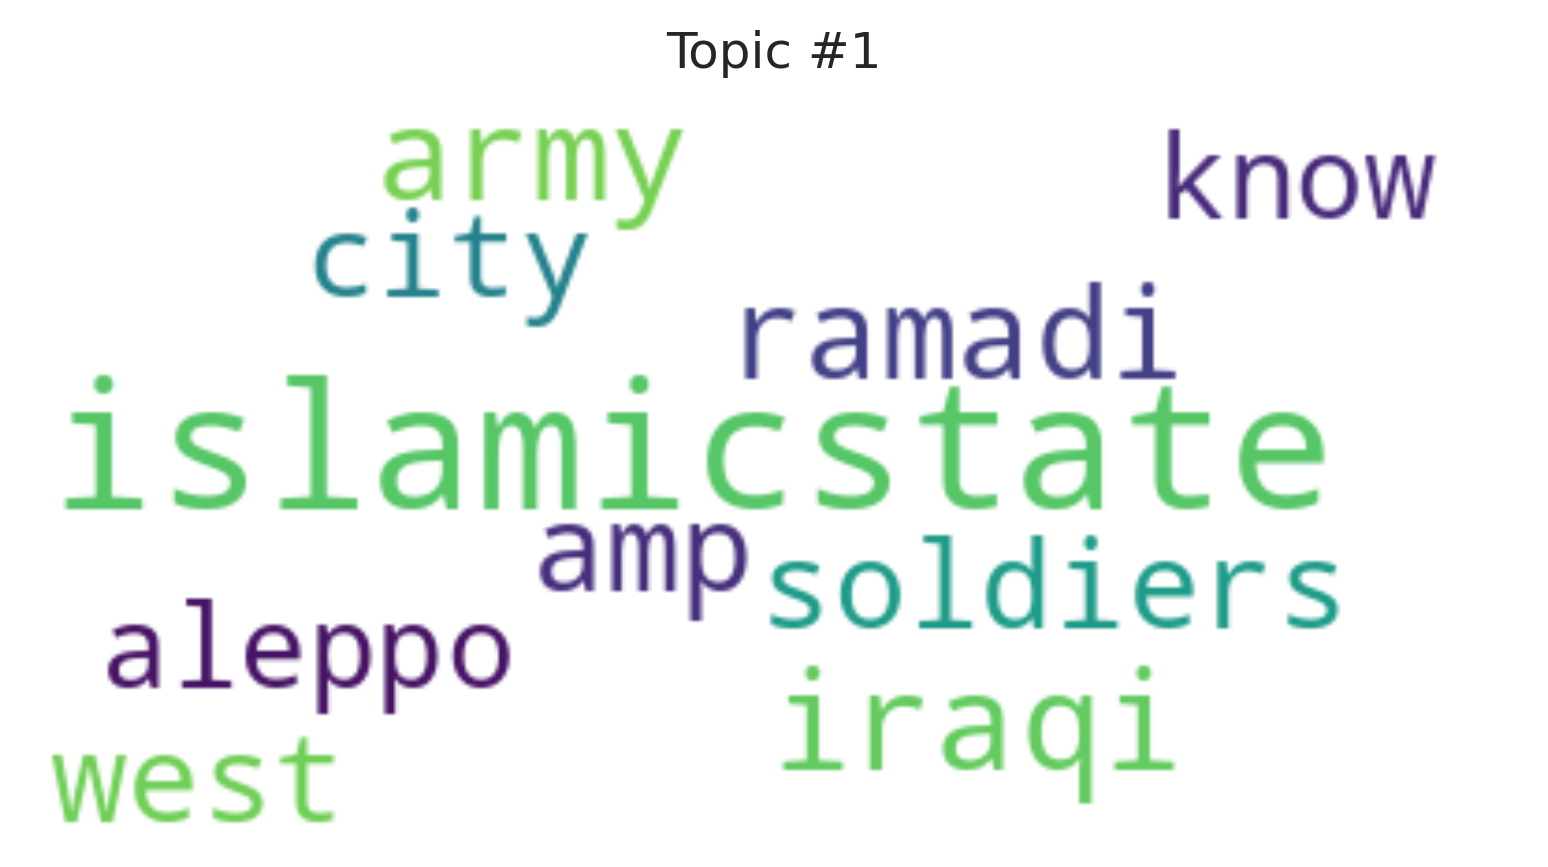

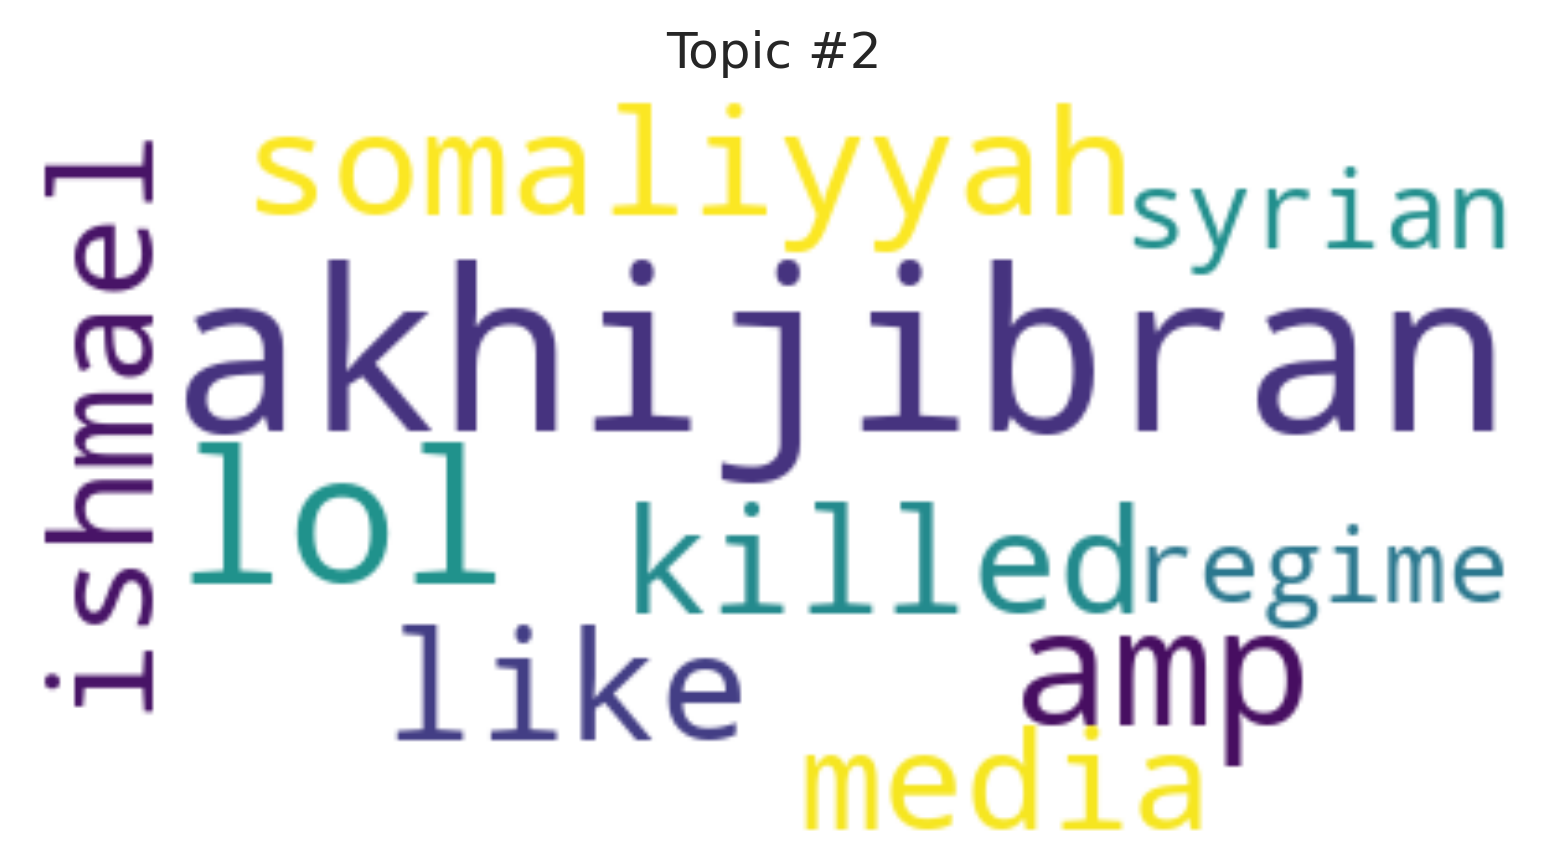

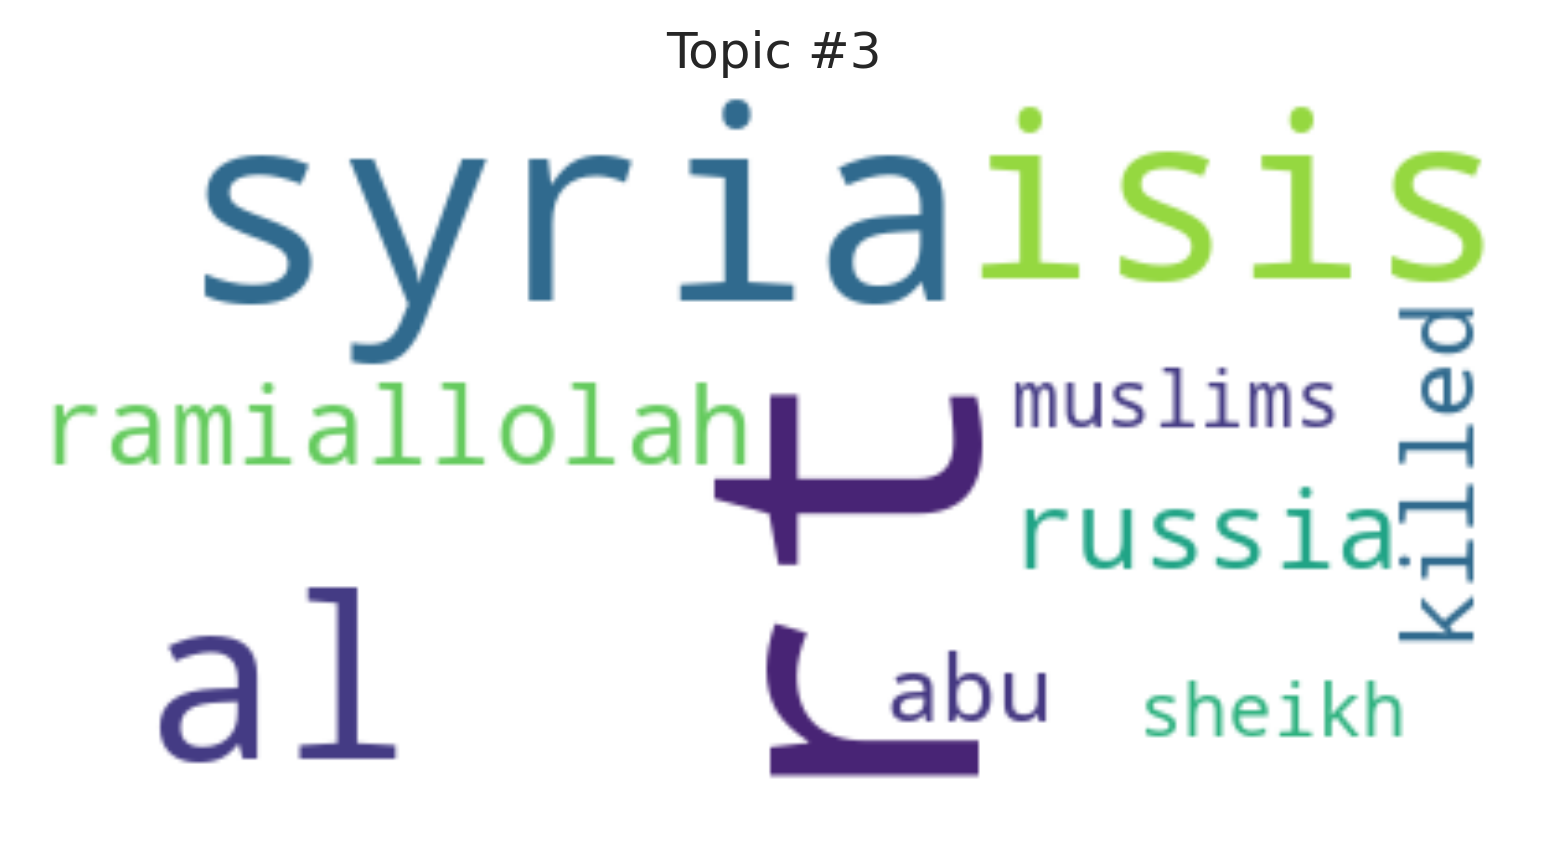

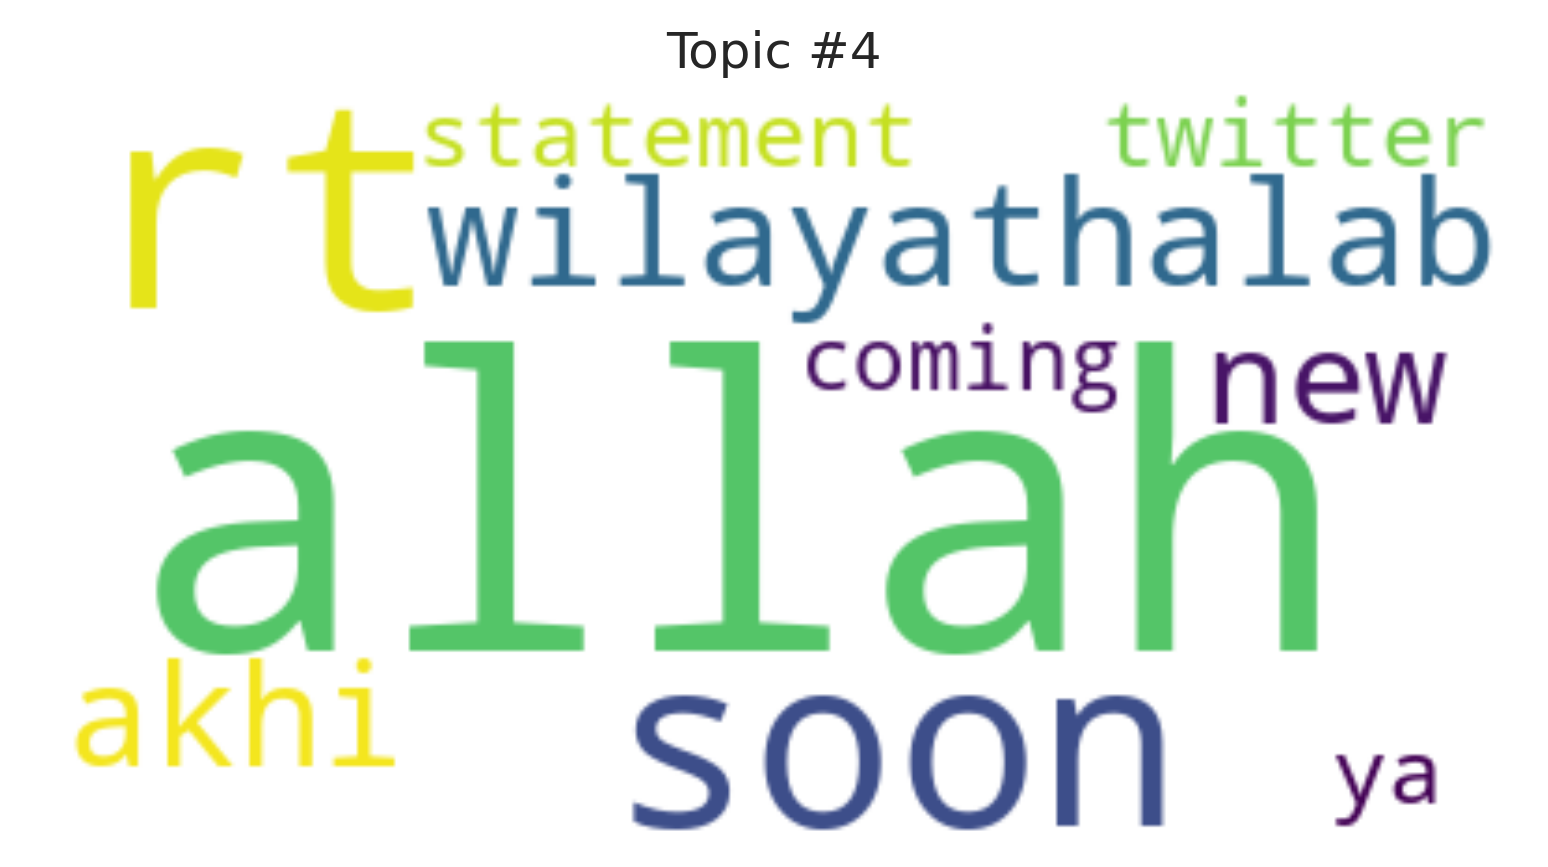

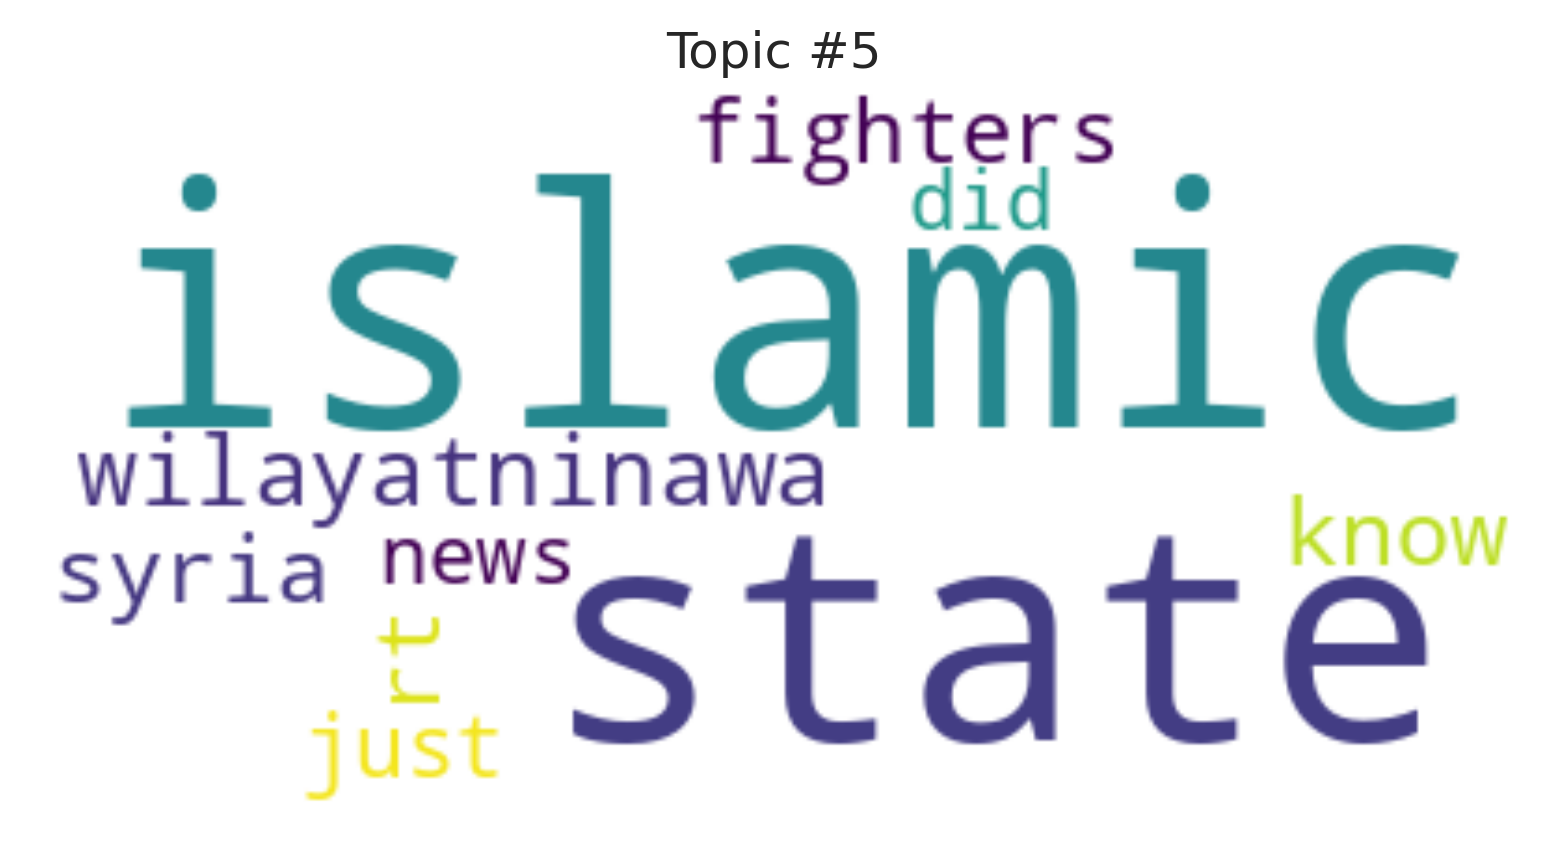

Word Clouds for 2016 Data:


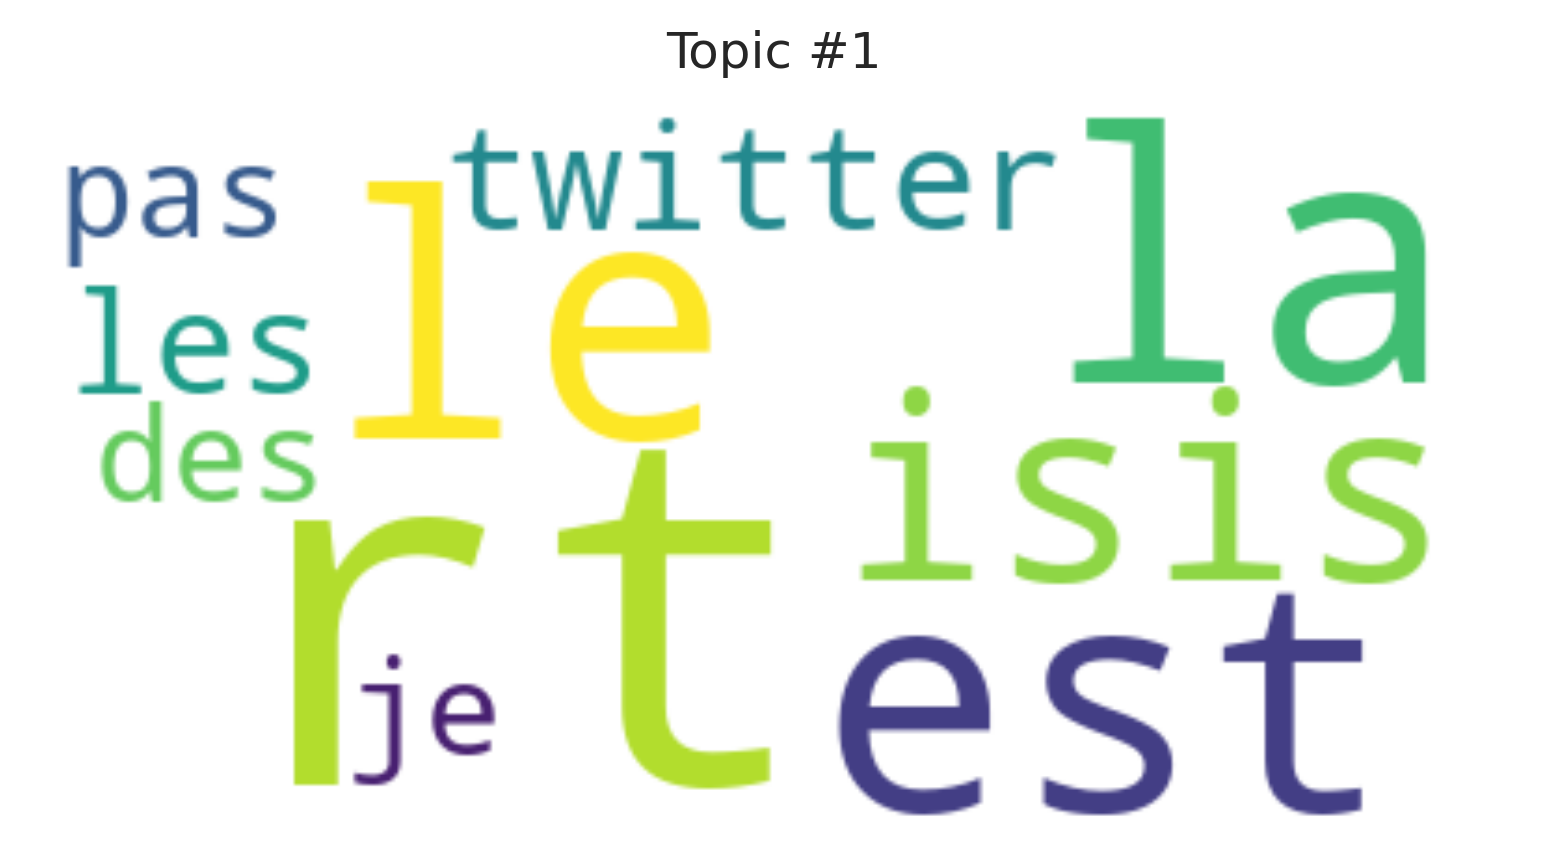

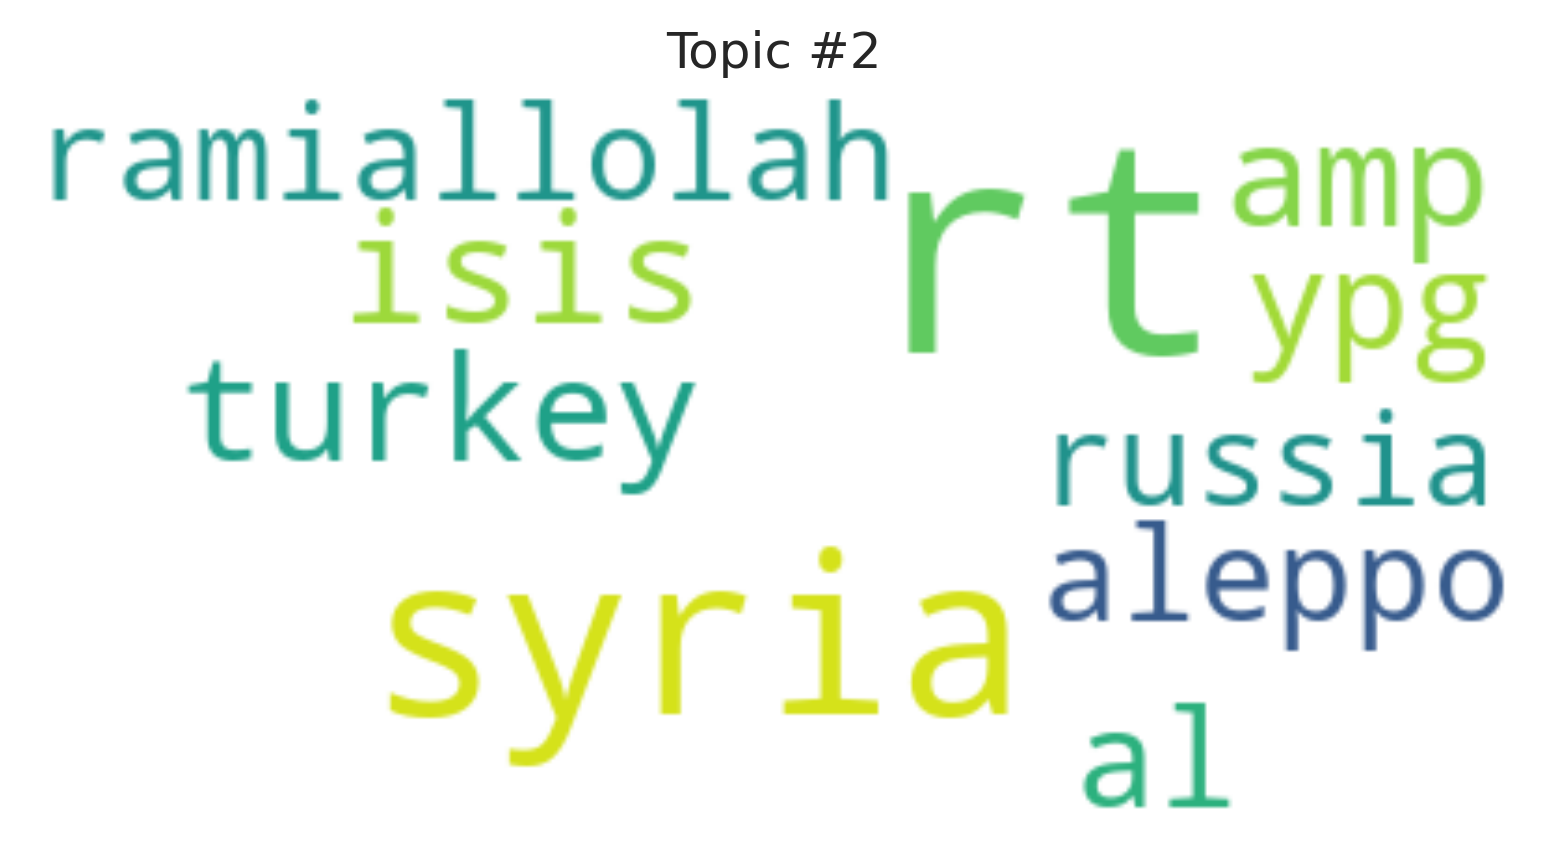

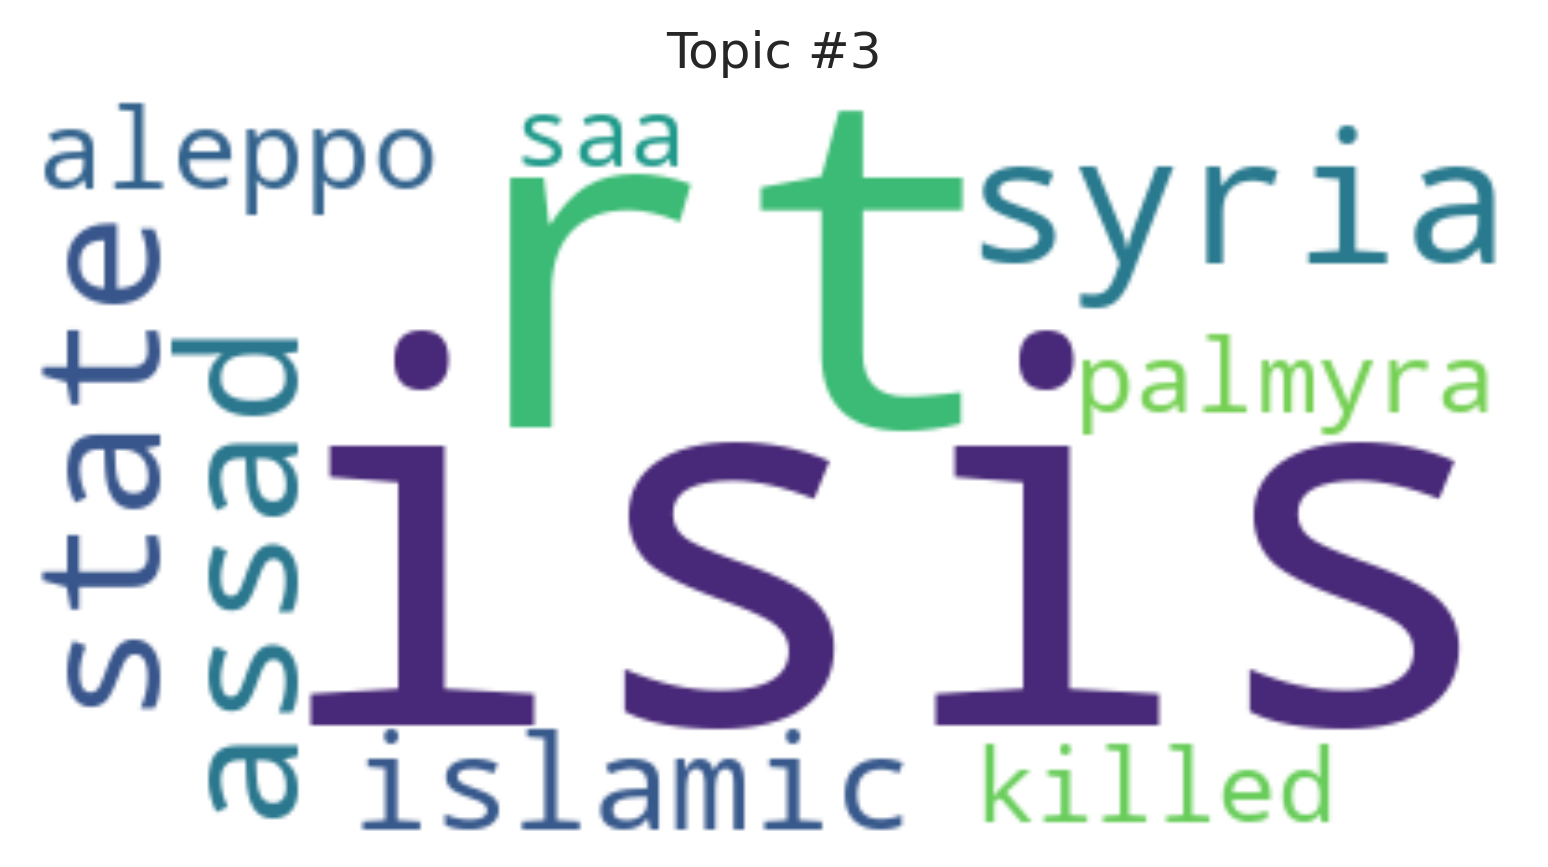

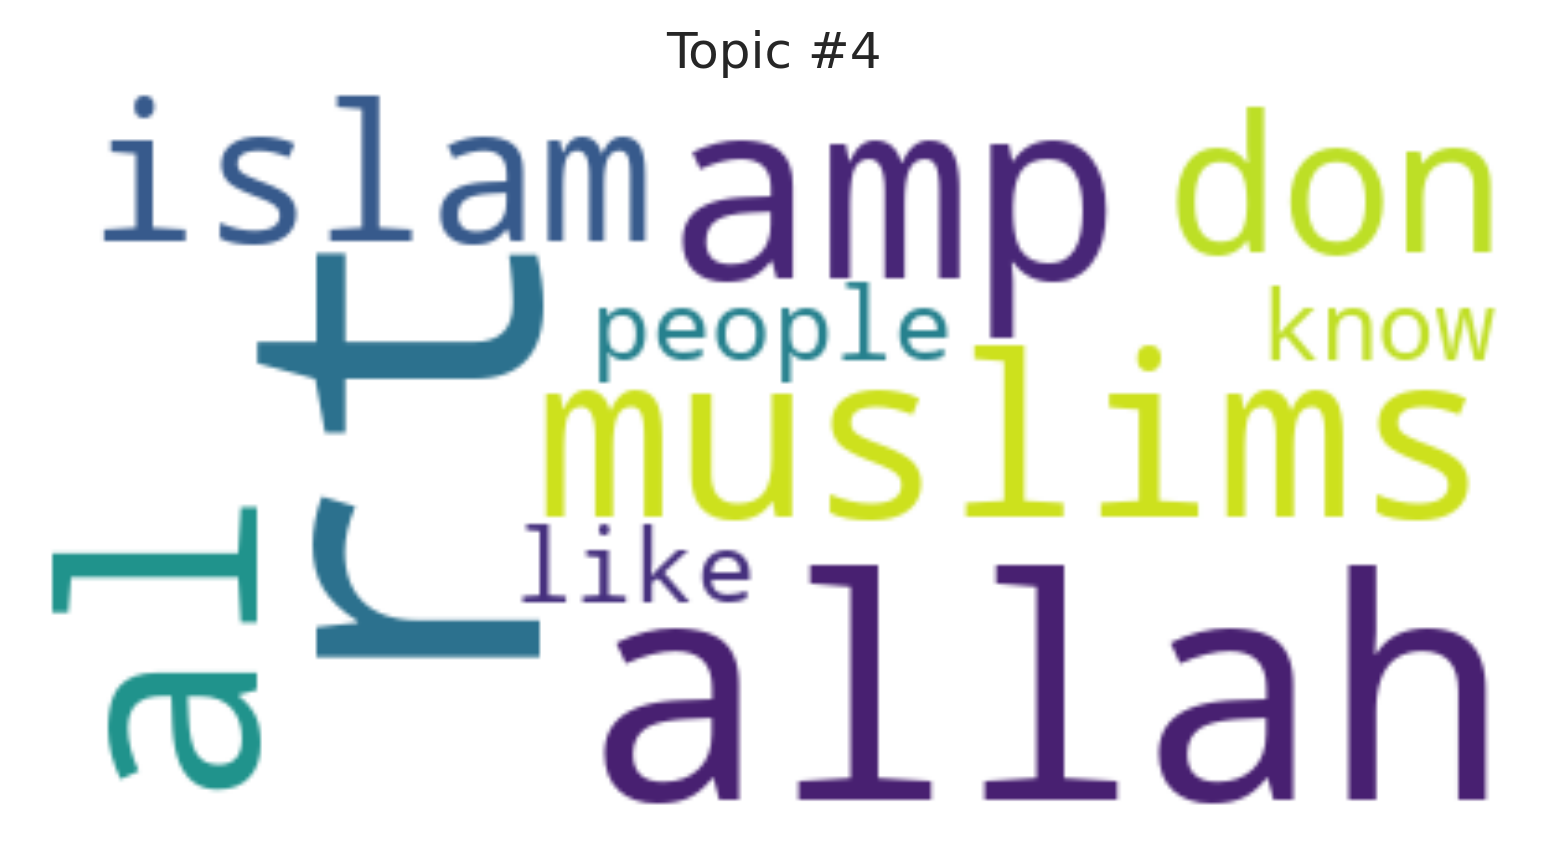

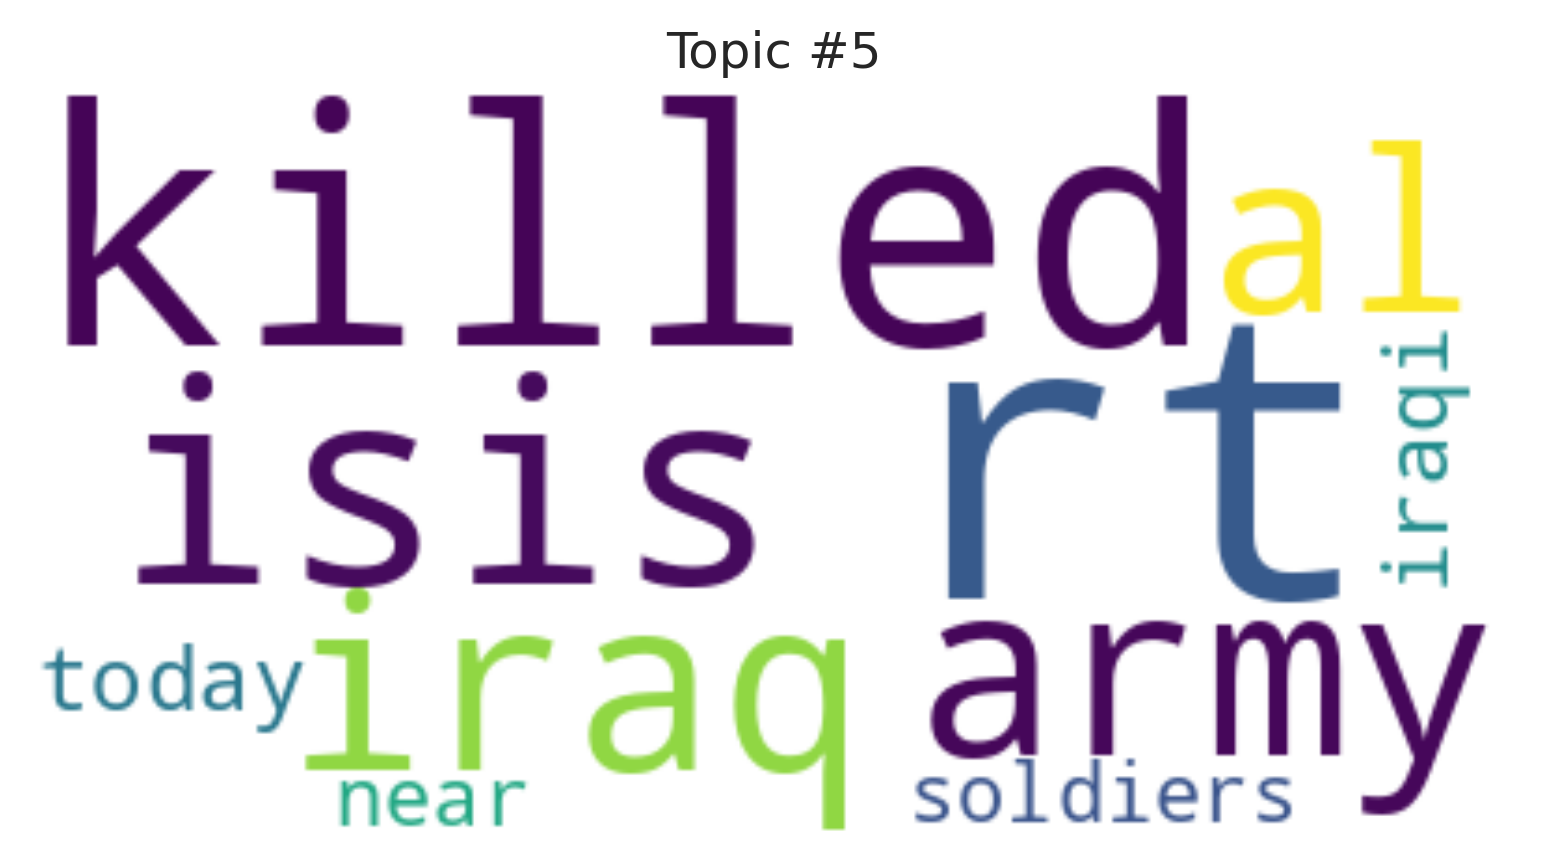

In [31]:
# Function to create and display word clouds for each topic
def plot_word_clouds(topics, num_topics):
    for i, topic in enumerate(topics):
        # Create a dictionary with words and their weights
        word_freq = {word: weight for word, weight in topic}
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Topic #{i+1}')
        plt.show()

# Adjust the get_topics function to include weights
def get_topics_with_weights(lda_model, vectorizer):
    keywords = np.array(vectorizer.get_feature_names_out())
    topics = []
    for topic_weights in lda_model.components_:
        top_keywords_locs = (-topic_weights).argsort()[:10]
        topics.append([(keywords[i], topic_weights[i]) for i in top_keywords_locs])
    return topics

# Get topics with weights for word cloud generation
topics_2015_with_weights = get_topics_with_weights(lda_model_2015, vrizer2015)
topics_2016_with_weights = get_topics_with_weights(lda_model_2016, vrizer2016)

# Plot word clouds for 2015 data
print("Word Clouds for 2015 Data:")
plot_word_clouds(topics_2015_with_weights, num_topics)

# Plot word clouds for 2016 data
print("Word Clouds for 2016 Data:")
plot_word_clouds(topics_2016_with_weights, num_topics)


## **Part 6: Visual Representation for Results of Above/Below Median Follower Count Subsets**

**Hisogram of LDA Results**

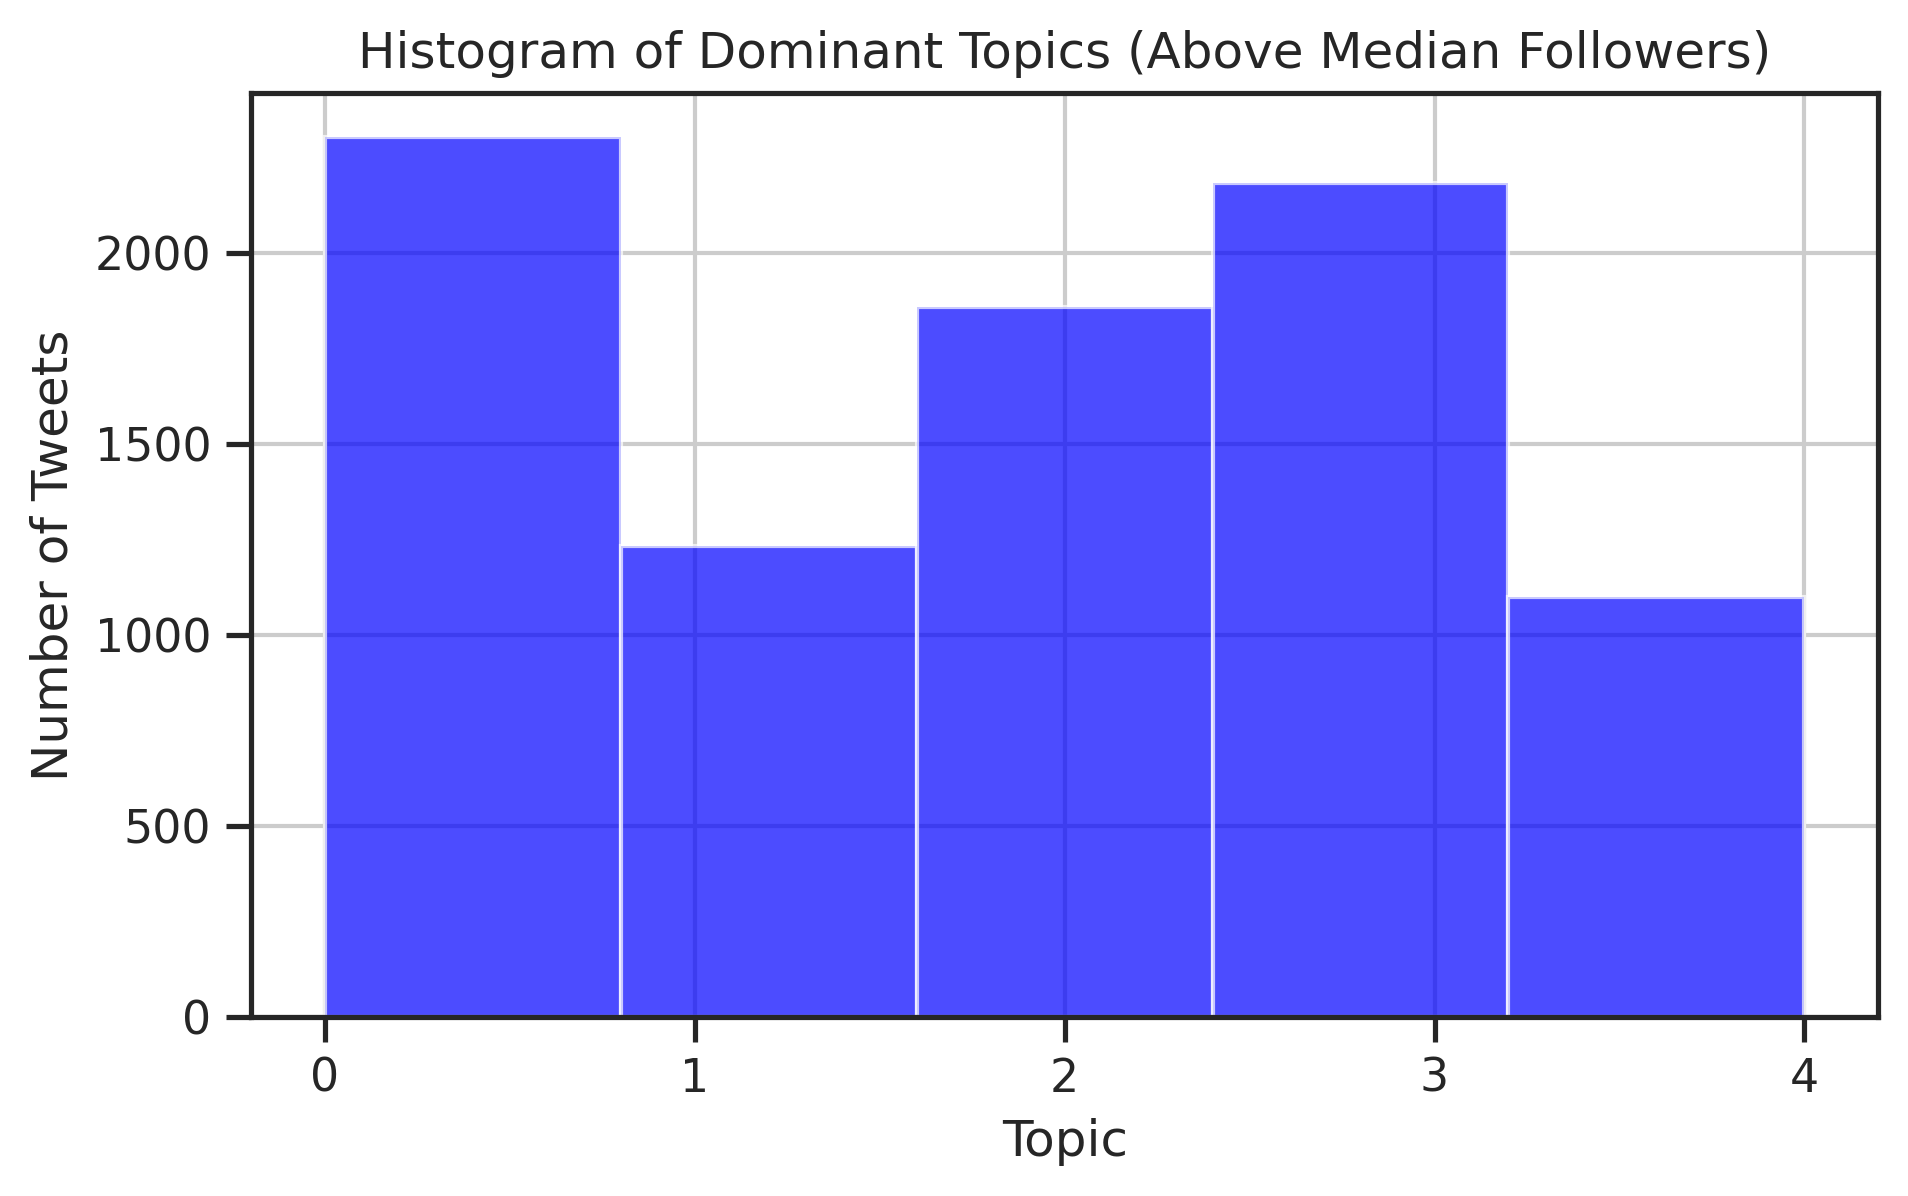

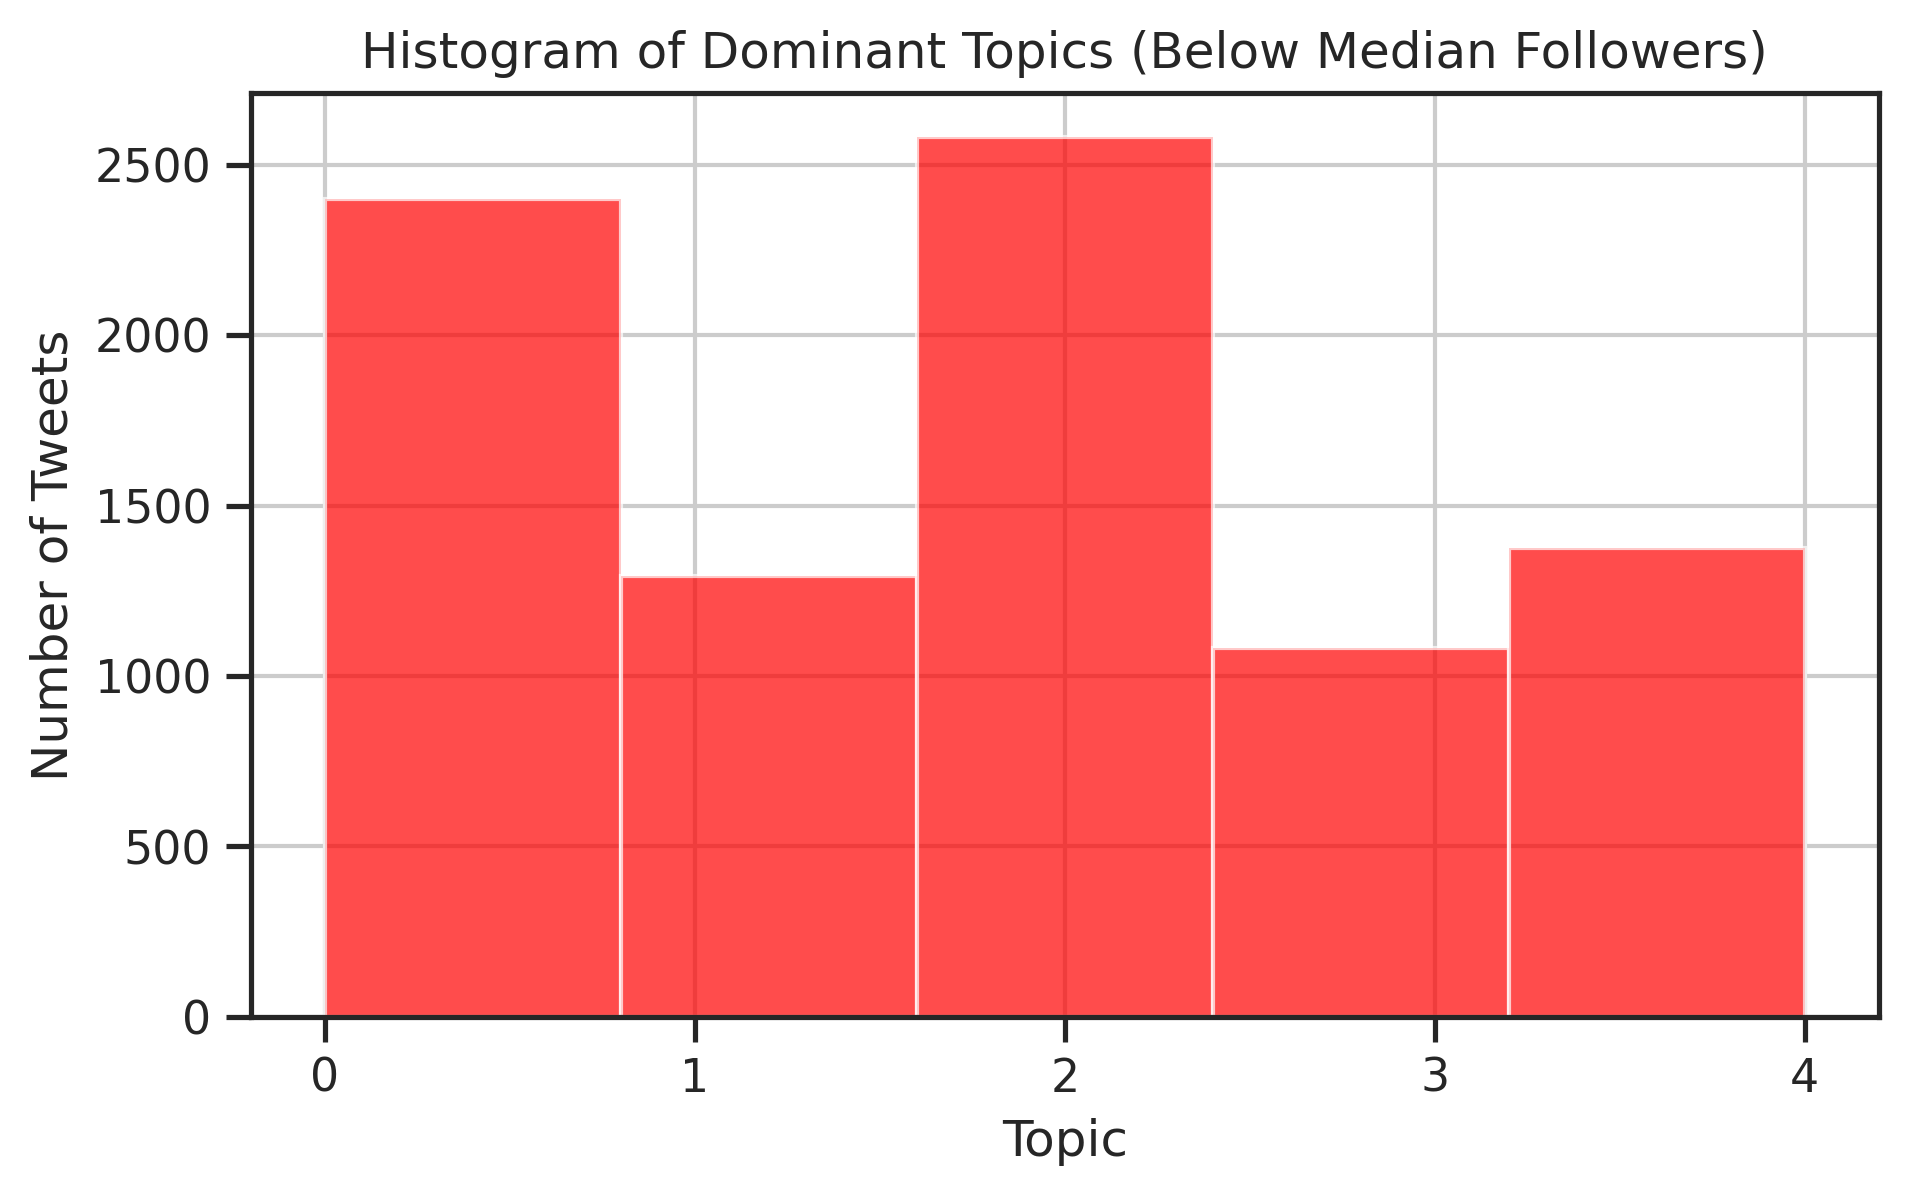

In [32]:
# Function to get the dominant topic for each document
def get_dominant_topic(lda_model, X):
    dominant_topic = [np.argmax(lda_model.transform(doc)) for doc in X]
    return dominant_topic

# Get dominant topics for above and below median follower datasets
dominant_topics_above_median = get_dominant_topic(lda_model_above_median, X_above_median)
dominant_topics_below_median = get_dominant_topic(lda_model_below_median, X_below_median)

# Plot histogram for above median follower dataset
plt.figure(figsize=(7, 4))
plt.hist(dominant_topics_above_median, bins=num_topics, color='blue', alpha=0.7)
plt.title('Histogram of Dominant Topics (Above Median Followers)')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.xticks(range(num_topics))
plt.grid(True)
plt.show()

# Plot histogram for below median follower dataset
plt.figure(figsize=(7, 4))
plt.hist(dominant_topics_below_median, bins=num_topics, color='red', alpha=0.7)
plt.title('Histogram of Dominant Topics (Below Median Followers)')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.xticks(range(num_topics))
plt.grid(True)
plt.show()